# PCA for Dimensionality Reduction

In this notebook we explore Principal Component Analysis (PCA) and how it can be used to interpret high dimensional datasets in lower dimensions. 
To do so, we review concepts from linear algebra to get a fuller understanding of what's going on and why PCA works.

We first review how PCA is defined, what exactly the principal components are, and how PCA allows us to reduce the dimensionality of our dataset in a *good* way. 
Then we generate a few toy datasets to conduct PCA and see how we use the principal components to plot the data in fewer dimensions. 
Finally we conclude by taking a closer look into how PCA relates to the singular value decomposition of a dataset. 


Suppose we have a dataset $X$ of $n$ samples where each sample is described by $m$ real valued features. 
For the purpose of dimensionality reduction, our goal will be to find a matrix $Y$ of size $n \times d$ where $d << m $ and $Y$ approximates $X$ 
(that is, $Y$ still captures the underlying properties of the dataset.)
In this way, the $d$ remaining attributes would be the componenets of $X$ that capture the most relevant information of our dataset, or are its **principal components**.

There are many ways we could do so. One is simply dropping features that are not relevant,
while another is learning some dependencies between features(if they exist) and drop the unnecessary features.
Yet it's not clear how we can do either in a way where we don't discard information about our dataset that is necessary. 

To help motivate what PCA does, first observe that for each feature we can compute the mean of that feature:
$$
\bar{x} = \sum_{k=1}^{n}x_k
$$

We can then compute the variance of the feature (the spread each data point is from the mean):
$$
\sigma_{i}^{2} = \frac{1}{n}\sum_{k=1}^{n} (x_k - \bar{x})^2
$$

A low variance indicates the data points are close to the mean. 
If $\sigma_{i}^{2} \sim 0$ then a good approximation for each $x_i$ would be $\bar{x}_i$. 
In this case we could replace each of the $n$ values $x_i$ with a single value $\bar{x}_i$.

We can extend this to considering the variance between two features. This is defined as the **covariance** between two features:
$$
c_{xy} = \frac{1}{n} \sum_{k=1}^{n} (x_i - \bar{x})(y_i - \bar{y})
$$

Consider when the covariance is either negative, positive, or zero. These scenarios can occur when:
1. Greater (than the mean) values of one variable mostly correspond with lesser (than the mean) values of the other variable (negative times positive and positive times negative are negative values.)
2. Greater values of one variable mostly correspond with greater values of the other variable (similarly for lesser values - positive times positive and negative time negative are positive values.)
3. There is no correspondance between the values: we'll have a mix of 1. and 2. which when summed together will be zero.

In cases 1. and 2. there is either a negative or positive correlation between the two variables respectively. 
That is, knowing the value of one variable gives us an estimation of what the value of the other variable is. 
In this way analyzing the covariance between different features within our dataset will provide a means to reduce the number of features we have. 

## Covariance Matrix, Eigenvectors, and Eigenvalues

For $m$ features in our input matrix, we can compute the covariance between $m^2$ pairs of features.
This can be arranged into an $m \times m$ matrix $C$ where the main diagonal contains $c_{xx}$ for each feature $x$.
Because $c_{xy} = c_{yx}$ this matrix will be symmetric around the diagonal.

The covariance matrix of our dataset will be used to calculate its principal components by considering what the eigenvectors/values of the matrix are.
We define what these are here, and leave a deeper insight into why at the end of this notebook.

Consider a a vector $x$ in which we apply a linear transform to specified by a matrix $A$.
If we can find some constant value $\lambda$ such that this transform is equal to scaling the values of $x$ by this constant, then we say $x$ is an **eigenvector** of $A$ with $\lambda$ being its **eigenvalue** (together they are an **eigenpair**.)

$$
Ax = \lambda x
$$

A matrix may have multiple eigenvectors. 
What's key to note about an eigenvector is that when applying $A$ to the vector, the direction of the vector doesn't change - it is only scaled by some value. 
That is there is something fundamental about the direction of eigenvectors that any points in this direction are only scaled by applying $A$ to them. 


## Computing the Principal Components

We now define the steps for computing the principal components of our dataset. 
We then walk through these steps by running them on a toy dataset and visualizing how we use PCA to reduce the dimensions of our dataset. 
Finally we dive a little deeper into what's happening in these steps to justify them.

1. Normalize our data by mean-centering it.
2. Compute covariance matrix.
3. Compute eigenvectors and eigenvalues on convariance matrix.
4. Sort principal components by decreasing eigenvalues.
5. Select top 5 principal components as our new features.

We use several Python packages to assist with the computations (see the `requirements.txt` file to install.)

In [1]:
# Import packages that will be used
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
# Generate dataset containing n datapoints with 3 features
n = 25
x1 = np.random.normal(3, 1, n)
x2 = np.random.normal(1, 2, n)
# NOTE: For this toy example introduce a dependency for feature x3.
x3 = 3*x1 - x2 + np.random.normal(0, 0.5, n)
X = np.array([x1, x2, x3]).transpose()
X

array([[ 3.49095579, -2.60346239, 12.88160894],
       [ 2.83551675,  2.19970943,  5.0170287 ],
       [ 2.24521246,  5.26198473,  0.95728833],
       [ 1.69653602,  2.96048685,  2.17651953],
       [ 2.36908531, -0.20612395,  7.47110784],
       [ 2.04493537,  2.51260612,  4.05279205],
       [ 4.07651704,  4.5982923 ,  7.71248966],
       [ 2.07150095,  0.38941248,  6.16850084],
       [ 2.22859268, -3.50857561, 10.38755268],
       [ 2.96227627, -0.70092244,  9.57183587],
       [ 1.28791974,  0.6277568 ,  3.38034134],
       [ 1.96958058, -1.67044821,  7.11684838],
       [ 3.66067904,  0.32590958, 10.09452495],
       [ 2.41154184, -0.92037189,  7.54724774],
       [ 2.56370096, -2.08946126, 10.0678991 ],
       [ 3.769373  ,  4.58254103,  7.69179094],
       [ 2.31866687, -0.4438195 ,  7.42950756],
       [ 2.38928504,  3.36407263,  3.62356717],
       [ 4.35002186, -1.12619892, 14.38069685],
       [ 3.32000969, -0.39715875, 11.64933883],
       [ 1.62000062,  3.81472012,  0.241

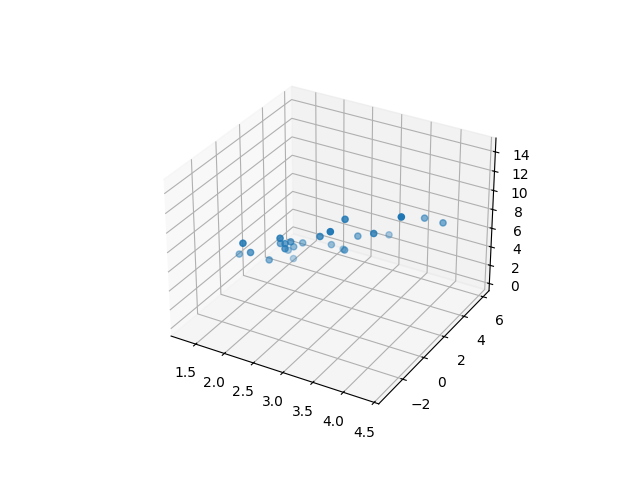

In [3]:
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
plt.show()

# Because of our dependency, see how most datapoints seem to line on a 2D plane. 
# This suggests we should be able to reduce our data to 2 dimensions. 

In [4]:
# 1. normalize data
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

array([[ 1.11754842, -1.47138294,  1.72527166],
       [ 0.28153818,  0.41877142, -0.45593378],
       [-0.4713929 ,  1.62384448, -1.58188424],
       [-1.17122781,  0.71815416, -1.24373603],
       [-0.3133935 , -0.52797723,  0.22469387],
       [-0.72684564,  0.54190319, -0.72336041],
       [ 1.86442977,  1.36266683,  0.29164002],
       [-0.69296133, -0.29362047, -0.13657824],
       [-0.49259137, -1.82756501,  1.03355654],
       [ 0.44321951, -0.72269138,  0.8073212 ],
       [-1.69241646, -0.19982671, -0.90986155],
       [-0.82296041, -1.10422122,  0.12644163],
       [ 1.33402984, -0.31861027,  0.95228663],
       [-0.25924035, -0.8090496 ,  0.24581092],
       [-0.06516192, -1.26911212,  0.94490207],
       [ 1.4726686 ,  1.35646836,  0.28589932],
       [-0.37770205, -0.62151569,  0.21315622],
       [-0.28762883,  0.87697409, -0.84240397],
       [ 2.21328421, -0.89004708,  2.14103685],
       [ 0.89950725, -0.60315365,  1.38350717],
       [-1.26884845,  1.05431385, -1.780

In [5]:
# 2. Calculate covariance matrix
C = np.cov(X, ddof=1, rowvar=False)
C

array([[ 1.04166667,  0.0094913 ,  0.71752917],
       [ 0.0094913 ,  1.04166667, -0.7321547 ],
       [ 0.71752917, -0.7321547 ,  1.04166667]])

In [6]:
# 3. Compute eigenvectors and eigenvalues on convariance matrix
eigenvalues, eigenvectors = np.linalg.eig(C)
print("Eigenvectors:", eigenvectors)
print("Eigenvalues:", eigenvalues)

Eigenvectors: [[ 4.96167708e-01 -7.14205472e-01  4.93688312e-01]
 [-5.06094632e-01 -6.99936075e-01 -5.03942174e-01]
 [-7.05468517e-01 -1.86828804e-04  7.08741234e-01]]
Eigenvalues: [0.01177752 1.05115604 2.06206644]


In [7]:
# 4. Sort principal components
ordered = np.argsort(eigenvalues)[::-1] # reverse to have highest to lowest
sorted_eigenvalues = eigenvalues[ordered]
sorted_eigenvectors = eigenvectors[ordered]
print("Eigenvectors:", sorted_eigenvectors)
print("Eigenvalues:", sorted_eigenvalues)
print("Explained variance:", sorted_eigenvalues / np.sum(sorted_eigenvalues))

Eigenvectors: [[-7.05468517e-01 -1.86828804e-04  7.08741234e-01]
 [-5.06094632e-01 -6.99936075e-01 -5.03942174e-01]
 [ 4.96167708e-01 -7.14205472e-01  4.93688312e-01]]
Eigenvalues: [2.06206644 1.05115604 0.01177752]


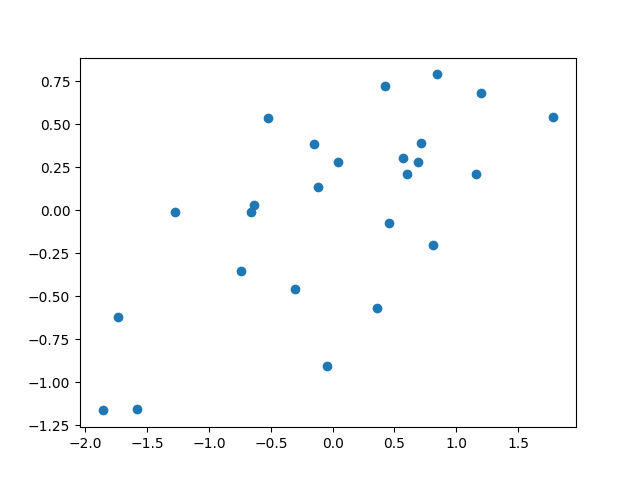

In [8]:
# 5. Dimension reduction
k = 2
R = np.matmul(X, sorted_eigenvectors[:, :k])
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.scatter(R[:,0], R[:,1])
plt.show()

## Principal Components of a Dataset 

Suppose we have a dataset of $n$ samples. Each sample is measured by one of $m$ attributes.
We can interpret this as a matrix $X$ of size $n \times m$  where each row vector corresponds to a sample. 
For the purpose of dimensionality reduction, we would like to find a matrix $Y$ of size $n \times d$ where $d << m $ and $Y$ approximates $X$ 
(that is, $Y$ still captures the underlying properties of the dataset.)
In this way, the $d$ remaining attributes would be the componenets of $X$ that capture the most relevant information, or are the **principal components** of $X$.

Before we see how we can compute these componenets, let's consider some scenarios where such a reduction can occur. 
One possibility is a set of attributes within the dataset are the same for each sample - there is no information that these attributes have that allow us to distinguish one sample from another. 
Therefore we could easily remove this set of attributes shrinking the size of $X$.
Typically this is not the case however and there is some variability between sample values for a particular attribute. 
An attribute that has less variability amongst its values may contain less information than an attribute with high variability and therefore could be removed from $X$ to generate $Y$.

Another possiblity is there are some dependency between attributes within the data. 
For example, if we find $x_i = x_j + x_k$ for all samples and attributes $i,j,k$ then attribute $i$ is dependent on $j$ and $k$ and could be removed.


## Linear Algebra Recap: SVD, Eigenpairs, etc.

To make the steps to PCA clearer, we first review some concepts from linear algebra. 
We do not aim to prove any statements here but encourage the reader to dive deeper into them using resources like
Gilber String's introduction to linear algebra books or Brunton and Kutz's [Data Drive Science & Engineering](https://databookuw.com/databook.pdf) book.

### Means and Variance

Given $n$ samples and $m$ attribute vectors, we can compute what the **mean value** is for each attribute is, and compare each value to how it differs from the mean. 
We can then define what the variance for each attribute is. 
However we can further extend this by considering what the variance is between any two attributes. 
These are combined into a single $m \times m$ matrix called the **covariance** matrix. 

If our dataset is mean centered (the mean rows of $X$ are 0) it follows that the covariance matrix of $X$ is
$$
C = \frac{1}{n-1}X^TX
$$

### Singular Value Decomposition (SVD)

The SVD of a matrix $X$ is a decomposition of $X$ into 3 special matrices:
$$
X = U \Sigma V^T
$$
where 
- $U$ is the left singular value vectors, a $n \times n$ matrix,
- $\Sigma$ is a real, non-negative valued diagonal matrix (zeros off the main diagonal - contains 0s below if $n \geq m$), a $m \times n$ matrix, and
- $V$ is the right singular value vectors, a $m \times m$ matrix.

There are other notable properties are:
1. The order of $u_1, u_2, ..., u_n$ is such that $u_1$ describes the variance in the cols of $X$ more than $u_2, ..., u_n$, $u_2$ describes the variance in the cols of $X$ more than $u_3, ...$, and so on.
2. $U$ and $V$ are unitary matrices such that $U^TU = V^TV = I$ (the identity matrix.)
3. The entries of $\Sigma$ are $\sigma_1, \sigma_2, ...$ and are ordered such that $\sigma_1 \geq \sigma_2 \geq ... \geq 0$.
4. Columns within $U$ and $V$ are orthonormal.

We do not concern ourselves with how the decomposition can be calculated (Python's `numpy` package provides our implementation) only that such a decomposition exists. 

### Eigenvalues and Eigenvectors

For a matrix $A$ of size $n \times n$, the vector $v$ and value $\lambda$ are called eigenvector and eigenvalue if
$$
Av = \lambda v
$$
A key property of eigenvectors are vectors which are only changes by a scalar value whenever a linear transformation is applied to them.

If we stack all the eigenvectors together into a $n \times n$ matrix $V$ we have
$$
AV = V \Lambda
$$
where $\Lambda$ is a diagonal matrix with matrix filled with eigenvalues.

## SVD and PCA

We now see how the SVD of our dataset relates to its principal components. 
First we mean center our dataset. We then compute $X^TX$ using the SVD of $X$
$$\begin{aligned}
X^TX &= (U \Sigma V^T)^T (U \Sigma V^T) \\
&= V \Sigma^T U^T U \Sigma V^T \\
&= V \Sigma^T \Sigma V^T \\
&= V D V^T
\end{aligned}$$

where $D = \Sigma^T \Sigma$ is a diagonal with squares of singular values and making note of $U$ being a unitary matrix. 

Now we compute $(X^TX)V$ using the above

$$\begin{aligned}
(X^TX)V &= (V D V^T) V \\
(X^TX)V &= V D
\end{aligned}$$
as $V$ is a unitary matrix. 

We now observe that $V$ is the eigenvectors of, not our dataset $X$, but $X^TX$ and that $D$ contains our eigenvalues (which are $\sigma_1^2, \sigma_2^2, ...$).
But since our dataset is mean centered, we know that $X^TX = (n-1)C$ our dataset's covariance matrix scaled by $n-1$. 


In [8]:
# PCA
# 1. normalize data
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

array([[-0.1151217 , -0.18588461, -0.04055357],
       [-0.26180958, -0.79597078,  0.02728405],
       [ 1.11045726, -0.69713149,  1.16323943],
       [ 1.1053513 , -1.40453113,  1.47264356],
       [ 1.05631077,  1.97730721, -0.07602271],
       [ 0.63094155,  0.32498768,  0.52310101],
       [ 1.45238009,  1.26322583,  0.50626561],
       [ 0.009313  , -0.02072463, -0.12243413],
       [-0.03905326, -0.71657058,  0.5061439 ],
       [ 1.96968528, -0.86045234,  2.13074712],
       [-0.45830106,  2.14563206, -1.3213725 ],
       [-1.71023206, -0.37278424, -1.34706531],
       [-0.5870927 ,  0.20193109, -0.43487816],
       [-0.4950505 , -0.4614066 , -0.26015524],
       [-0.46293122,  0.65113527, -0.65865073],
       [-0.40415983, -0.05984446, -0.37417203],
       [ 0.62311865, -0.48682572,  0.86664016],
       [ 0.79969425,  0.07171038,  0.66103397],
       [-0.70456739,  0.50070444, -0.96131739],
       [-0.93918504,  2.22846599, -2.01739418],
       [ 0.67784105, -0.2315094 ,  0.800

In [9]:
# 2. Calculate covariance matrix
C = np.cov(X, ddof=1, rowvar=False)
C

array([[ 1.04166667, -0.05102738,  0.90398709],
       [-0.05102738,  1.04166667, -0.54920608],
       [ 0.90398709, -0.54920608,  1.04166667]])

In [12]:
# 3. Compute eigenvectors and eigenvalues on convariance matrix
eigenvalues, eigenvectors = np.linalg.eig(C)
print("Eigenvectors:", eigenvectors)
print("Eigenvalues:", eigenvalues)

Eigenvectors: [[-0.6030067   0.60643999  0.51827932]
 [ 0.38380849 -0.34900154  0.85492044]
 [-0.69933823 -0.71444276  0.02230655]]
Eigenvalues: [2.12254599 0.00605159 0.99640242]


In [15]:
# 4. Sort principal components
ordered = np.argsort(eigenvalues)[::-1] # reverse to have highest to lowest
sorted_eigenvalues = eigenvalues[ordered]
sorted_eigenvectors = eigenvectors[ordered]
print("Eigenvectors:", sorted_eigenvectors)
print("Eigenvalues:", sorted_eigenvalues)

Eigenvectors: [[-0.6030067   0.60643999  0.51827932]
 [-0.69933823 -0.71444276  0.02230655]
 [ 0.38380849 -0.34900154  0.85492044]]
Eigenvalues: [2.12254599 0.99640242 0.00605159]


In [16]:
# 5. explained variance
sorted_eigenvalues / np.sum(sorted_eigenvalues)

array([0.67921472, 0.31884877, 0.00193651])

In [20]:
k = 2
R = np.matmul(X, sorted_eigenvectors[:, :k])

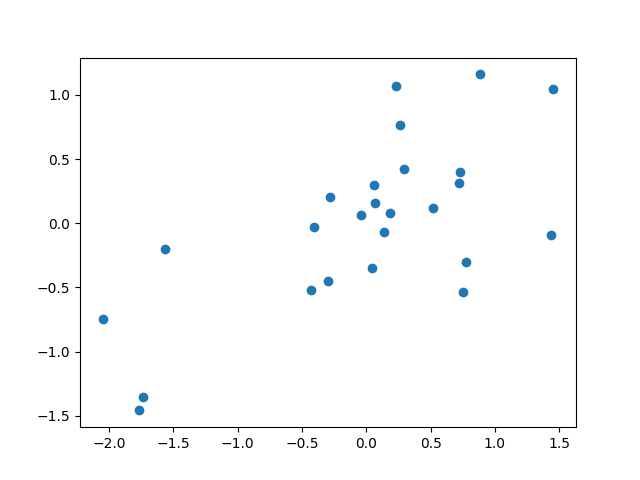

In [22]:
k = 2
R = np.matmul(X, sorted_eigenvectors[:, :k])
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.scatter(R[:,0], R[:,1])
plt.show()